In [1]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import copy
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# Read data 

In [3]:
df_labels = pd.read_csv("dataset/train.csv")
df_photo_to_biz = pd.read_csv("dataset/train_photo_to_biz_ids.csv")
df = df_photo_to_biz.join(other=df_labels.set_index('business_id'), how='left', on='business_id').drop(columns="business_id")

In [4]:
df_train = df_labels
df_train["photos_id"] = df_labels["business_id"].apply(lambda x: " ".join(map(str,df_photo_to_biz[df_photo_to_biz.business_id == x].photo_id.values)))

In [5]:
df_train.head()

,business_id,labels,photos_id
0,1000,1 2 3 4 5 6 7,438623 325966 227692 407856 368729 163193 2878...
1,1001,0 1 6 8,298536 20346 8457 308694 349310 407838 280304 ...
2,100,1 2 4 5 6 7,338465 328433 243861 361777 127198 466528 1592...
3,1006,1 2 4 5 6,46472 341947 396253 75316 42330 244095 171585 ...
4,1010,0 6 8,118251 219940 27517 8578 148347 433559 461006 ...


In [6]:
print(df_train.isnull().sum().sum())

4


In [7]:
df_train.dropna(inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [8]:
df_train.head()

,business_id,labels,photos_id
0,1000,1 2 3 4 5 6 7,438623 325966 227692 407856 368729 163193 2878...
1,1001,0 1 6 8,298536 20346 8457 308694 349310 407838 280304 ...
2,100,1 2 4 5 6 7,338465 328433 243861 361777 127198 466528 1592...
3,1006,1 2 4 5 6,46472 341947 396253 75316 42330 244095 171585 ...
4,1010,0 6 8,118251 219940 27517 8578 148347 433559 461006 ...


Business attributes, that corresponds to labels:

0: good_for_lunch

1: good_for_dinner

2: takes_reservations

3: outdoor_seating

4: restaurant_is_expensive

5: has_alcohol

6: has_table_service

7: ambience_is_classy

8: good_for_kids


In [9]:
labels_str = [
    "good for lunch", "good for dinner", "takes reservations",
    "outdoor seating", "restaurant is expensive", "has alcohol",
    "has table service", "ambience is classy", "good for kids"
]

In [10]:
LABELS_NUM = 9

In [11]:
def encode_label(l):
    res = np.zeros(LABELS_NUM)
    for i in l:
        res[i] = 1
    return res

train_L = np.vstack(df_train['labels'].apply(lambda x: tuple(sorted(int(t) for t in x.split()))).apply(encode_label))
df_train = pd.concat([df_train, pd.DataFrame(train_L)], axis=1).drop(columns=["labels"])
df_train.head()

,business_id,photos_id,0,1,2,3,4,5,6,7,8
0,1000,438623 325966 227692 407856 368729 163193 2878...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1001,298536 20346 8457 308694 349310 407838 280304 ...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,100,338465 328433 243861 361777 127198 466528 1592...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,1006,46472 341947 396253 75316 42330 244095 171585 ...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1010,118251 219940 27517 8578 148347 433559 461006 ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [12]:
def show_image(opencv_image):
    b,g,r = cv2.split(opencv_image)
    rgb_image = cv2.merge([r,g,b])
    plt.imshow(rgb_image)
    plt.show()

In [72]:
def get_img(img_id):
    return cv2.resize(cv2.imread("dataset/train_photos/" + str(img_id) + ".jpg"), (299, 299), interpolation = cv2.INTER_LINEAR)

In [14]:
df_train.head()

,business_id,photos_id,0,1,2,3,4,5,6,7,8
0,1000,438623 325966 227692 407856 368729 163193 2878...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1001,298536 20346 8457 308694 349310 407838 280304 ...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,100,338465 328433 243861 361777 127198 466528 1592...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,1006,46472 341947 396253 75316 42330 244095 171585 ...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1010,118251 219940 27517 8578 148347 433559 461006 ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


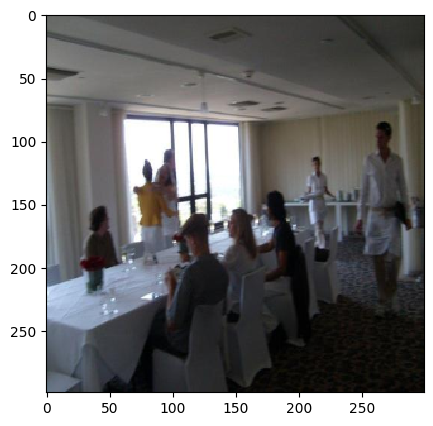

In [15]:
#show_image(get_img(int(df.sample(1).photo_id)))

# Data investigating

## Class balance

In [16]:
def show_classes_count(df):
    labels = df.drop(columns=["photos_id", "business_id"])
    labels_count = []
    for i in range(LABELS_NUM):
        labels_count.append(df[i].sum())
    plt.bar(x=range(LABELS_NUM), height=labels_count, tick_label=labels_str)

Generally, it is hard task to balance classes in multi-label classification, but let's try to do it in easy way. First, let's use upsampling for good for lunch, as it has the smallest amount os samples

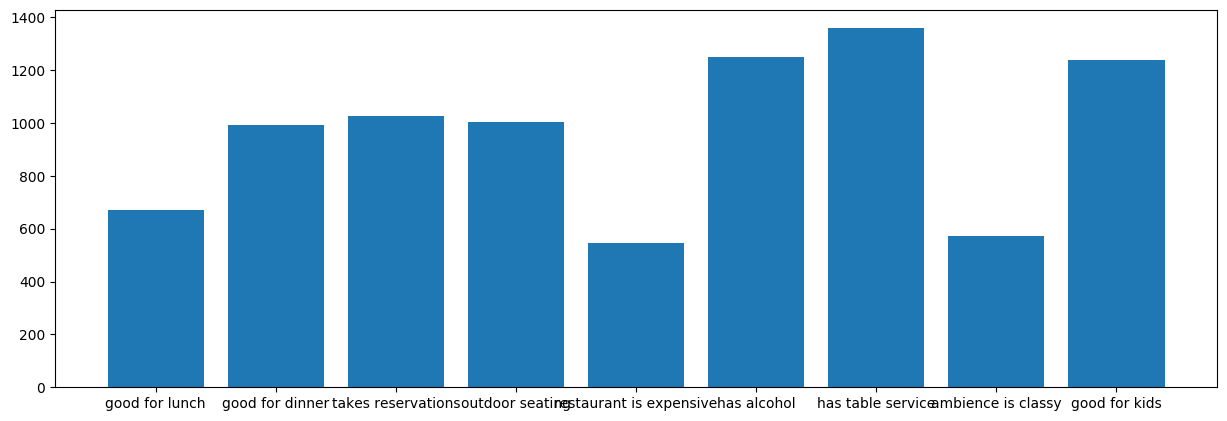

In [17]:
show_classes_count(df_train)

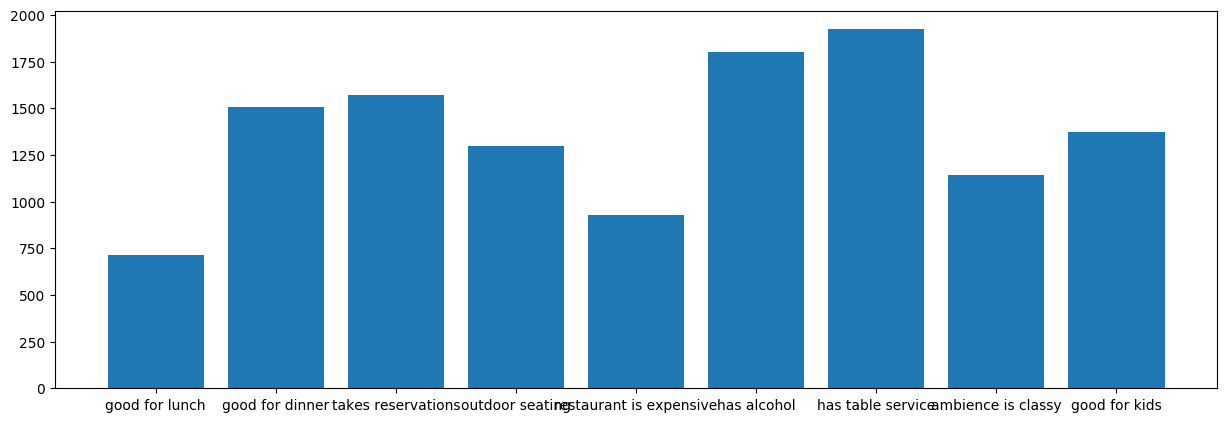

In [18]:
show_classes_count(df_train.append(df_train[df_train[7] == 1]))

We can see, that it improved the situation, but we have much more samples from 5 and 6 labels comparing to 4 and 7. So let's use downsampling for 5 and 6 classes, but while removing samples take into account, that samples, that have 0, 4 and 7 classes don't remove

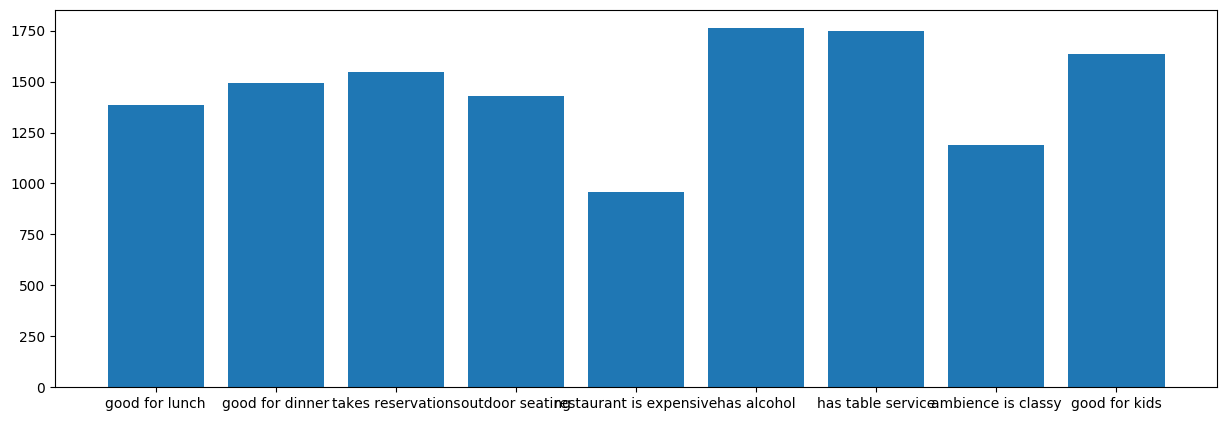

In [19]:
a = df_train[df_train[6] == 1]
a = df_train[df_train[5] == 1].append(a[a[5] == 0])
a = a[a[7] == 0]
a = a[a[4] == 0]
a = a[a[0] == 0]
a = df_train.iloc[list(set(df_train.index) - set(a.index))]
balanced_df = a.append(a[a[7] == 1])
balanced_df = balanced_df.append(a[a[0] == 1])
show_classes_count(balanced_df)

For now, 7 classs could have more samples, but generally classes are much more balanced

# Feature extraction

## Inception

In [30]:
from keras.applications import InceptionV3, ResNet50
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten
import tensorflow as tf

In [31]:
from operator import methodcaller

In [63]:
def get_images(df):
    return list(
        map(lambda x: list(map(get_img, x)),
            map(methodcaller("split", " "), df["photos_id"])))

In [33]:
df_train["feature"] = 0 

In [34]:
len(df_train)

1996

In [35]:
# imgs = get_images(df_train);

In [36]:
def modify_model(original_model):
    original_model.layers.pop()
    bottleneck_model = Model(inputs=original_model.inputs, outputs=original_model.layers[-1].output)

    for layer in bottleneck_model.layers:
        layer.trainable = False

    return bottleneck_model

In [40]:
model = modify_model(InceptionV3(weights='imagenet'))

In [73]:
imgs = get_images(cur_df.iloc[0:1])[0]

In [49]:
cur_df

,business_id,photos_id,0,1,2,3,4,5,6,7,8,feature
0,1000,438623 325966 227692 407856 368729 163193 2878...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"b'W!\x0e?\x0c\xa8\x7f=""+7?\xd1\xb0\x84>\xf8\xb..."
1,1001,298536 20346 8457 308694 349310 407838 280304 ...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,"b'W!\x0e?\x0c\xa8\x7f=""+7?\xd1\xb0\x84>\xf8\xb..."
2,100,338465 328433 243861 361777 127198 466528 1592...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,"b'W!\x0e?\x0c\xa8\x7f=""+7?\xd1\xb0\x84>\xf8\xb..."
3,1006,46472 341947 396253 75316 42330 244095 171585 ...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,"b'W!\x0e?\x0c\xa8\x7f=""+7?\xd1\xb0\x84>\xf8\xb..."
4,1010,118251 219940 27517 8578 148347 433559 461006 ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1991,991,313068 235331 233740 203161 199687 252037 3053...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0
1992,993,46350 195356 456918 111832 348718 378902 10706...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
1993,997,330500 212414 88663 366475 310263 250591 36948...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1994,998,72464 403533 18377 214226 143887 146995 276660...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0


In [47]:
len(imgs)

54

In [89]:
from multiprocessing import Pool

def get_feature(img):
    x = model.predict(inception_preprocess(np.expand_dims(image.img_to_array(img), axis=0)))
    return x
    
cur_df = df_train
for ind in range(len(cur_df)):
    imgs = get_images(cur_df.iloc[ind:ind+1])[0]
    features = list(map(get_feature, imgs))

    feature = np.array(features).mean(axis=0)
    cur_df.iloc[ind, -1] = feature.flatten().tostring()
    print(ind)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


KeyboardInterrupt: 

In [90]:
with open("1.csv", "w") as f:
    f.write(df_train.to_csv())

In [ ]:
feat.shape

In [ ]:
df_train.to_csv()

In [ ]:
df_train[df_train["business_id"][0]]

In [ ]:
feature = np.array(features).mean(axis=0)

In [ ]:
def split_and_stratify(df, percn_to_ignore):
    y = df.drop(["photos_id", ], axis=1)
    X_stratified, _ = train_test_split(df, test_size=percn_to_ignore, random_state=42, stratify=y)
    X_stratified["photo"]
    return X_stratified

In [93]:
import pandas as pd
import numpy as np
a = pd.read_csv("1.csv")
# eval(a["feature"].values[0])
a["feature"].apply(lambda x: np.fromstring(eval(x), dtype=np.float32))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte

In [ ]:
# import numpy as np
# [len(x) for x in a["feature"].values]